In [81]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

from sklearn.model_selection import train_test_split
np.random.seed(0)

In [2]:
TRAIN_DATA = 'F:/WISDOM/MIDS/Curriculum/W207/MyWork/ProjectFinal/data/training.csv'
TEST_DATA = 'F:/WISDOM/MIDS/Curriculum/W207/MyWork/ProjectFinal/data/test.csv'

IMAGE_ROWS = 96
IMAGE_COLS = 96
INPUT_SHAPE = (IMAGE_ROWS, IMAGE_COLS, 1)

In [3]:
# df_train = pd.read_csv(TRAIN_DATA)
# df_test = pd.read_csv(TEST_DATA)

def loader(test=False, seed=None, keeplabels=None):
    if seed:
        np.random.seed(seed)
    fileloc = TEST_DATA if test else TRAIN_DATA
    
    df = read_csv(fileloc)
    
    df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' '))
    
    if keeplabels:
        df = df[list(keeplabels) + ['Image']]
        
    df = df.dropna() # drop rows with missing labels
    
    X = np.vstack(df['Image'])
    # by pixel across the whole dataset subtract mean and divide by stdev
    X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
    X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
    X = X.astype(np.float32)
    
    if not test:
        y = df[df.columns.difference(['Image'])].values
        y = y.astype(np.float32)
        y = (y - 48) / 48 # this helps, but tanh on output doesnt
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
    else:
        y = None
    
    X = X.reshape(-1, 96, 96, 1)

    return X, y


In [3]:
# describe the data
# df_train.describe()

# split the data: train/test
# X, y = loader(seed=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                         test_size=0.2,
#                                                         random_state=42)
# data=[X_train, X_test, y_train, y_test]

df = read_csv(TRAIN_DATA)

#df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' '))
    

df.shape (2140, 31)


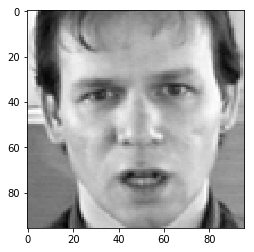

In [110]:
print("df.shape", df.shape)
df = df.dropna()

Y = df[df.columns.difference(['Image'])].values
X = df['Image']

imgArray = np.zeros((2140,9216))
#imgArray = X.apply( lambda x: np.fromstring(x, dtype=int, sep=' '), axis='columns' )        # errors out
idx=0
for i in X.keys(): 
    imgArray[idx] = np.fromstring(X[i], dtype=int, sep=' ')
    idx = idx + 1

thisImg = np.reshape(imgArray[21], (96,96))
plt.imshow(thisImg, cmap='gray')
plt.show()

X = imgArray

In [5]:
### shuffle and split dataset into train and test

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


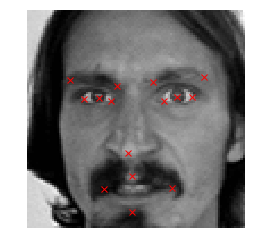

In [106]:

### function to plot an image with its keypoints (actual or predicted)

def plot_image(image, points, type='actual'):
    """Helper function to plot images"""
    plt.figure(figsize=(4,4))
    plt.imshow(np.reshape(image,(96,96)), cmap = 'gray')
    
    if( type=='actual' ):
        for x, y in np.reshape(points,(len(points)//2, 2)):
            plt.plot(x, y, 'rx')
    elif( type=='predicted'):
        for x, y in np.reshape(points,(len(points)//2, 2)):
            plt.plot(x, y, 'r*')    
    plt.axis('off')
    plt.show()

### function to plot an image and compare keypoints (actual versus predicted)
    
def plot_compare_images(image, points_act, points_pred ):
    """Helper function to plotand compare images"""
    plt.figure(figsize=(8,8))
       
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title("Actual")
    plt.imshow(np.reshape(image,(96,96)), cmap = 'gray')
    for x, y in np.reshape(points_act,(len(points_act)//2, 2)):
        plt.plot(x, y, 'rx')
        
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title("Predicted")
    plt.imshow(np.reshape(image,(96,96)), cmap = 'gray')
    for x, y in np.reshape(points_pred,(len(points_pred)//2, 2)):
        plt.plot(x, y, 'r*')  
   
    plt.show()

plot_image(X_train[0], Y_train[0], 'actual')


In [ ]:
labels = list(df_train.columns.difference(['Image']))
missing_groups_wcounts=(df_train.isnull()
 .groupby(labels)
 .apply(lambda x: np.ma.size(x, axis=1))
 .reset_index(level=labels, name="n_rows")
 .sort_values(by=['n_rows'], ascending=False)
 .reset_index(drop=True)
)
missing_groups_wcounts['Missing_Group_Number']=missing_groups_wcounts.index
missing_groups_wcounts.head(10)

In [6]:
print("Y.shape          ", Y.shape)
print("X.shape          ", X.shape)
print("Y_train.shape    ", Y_train.shape)
print("X_train.shape    ", X_train.shape)
print("Y_test.shape     ", Y_test.shape)
print("X_test.shape     ", X_test.shape)


Y.shape           (2140, 30)
X.shape           (2140, 9216)
Y_train.shape     (1712, 30)
X_train.shape     (1712, 9216)
Y_test.shape      (428, 30)
X_test.shape      (428, 9216)


In [87]:
### Setting prediction baseline using Gaussian Naive Bayes

gnb_predicted = np.zeros( Y_test.shape )

for thisFeat in range(0, Y_train.shape[1]):
    # # Defining model parameters for Multinomial NB (MNB)
    # mnb_model = MultinomialNB(alpha=1, fit_prior=True, class_prior=None)
    # # Fitting training dataset on the MNB model
    # mnb_model.fit(X, Y[:,thisFeat])
    # # Predict the dev dataset
    # mnb_predicted[:,thisFeat] = mnb_model.predict(X_test)
    # Defining default Gaussian NB model (GNB)
    gnb_model = GaussianNB()
    gnb_model.fit(X_train, Y_train[:,thisFeat].astype('int'))
    
    gnb_predicted[:,thisFeat] = gnb_model.predict(X_test)
    
    # # searching for optimum value of theta, sigma
    # gnb_params = {'sigma_': np.arange(0.01, 5.0, 0.1),
    #               'theta_': np.arange(0.01, 3.0, 0.05) }
    # 
    # # gscv_knn = GridSearchCV( estimator=gnb_model, param_grid=gnb_params, n_jobs=8, iid=True )
    # # gscv_knn.fit(X_train, Y_train[:,thisFeat].astype('int'))
    # # print('Optimum sigma_ value: {}'.format(gscv_knn.best_params_['sigma_']))
    # # print('Optimum theta_ value: {}'.format(gscv_knn.best_params_['theta_']))
    

In [88]:
### Comparing accuracy and F1 scores

accu = np.zeros(30, dtype=float )
f1Score = np.zeros(30, dtype=float )

def nb_accuracy(true_data, pred_data, mode='fraction'):
    
    model_errs = 0                                                             # errors accumulator
    for i in range(0, pred_data.shape[0]):
        if( pred_data[i] != true_data[i] ):
            model_errs += 1
    if( mode=='percent' ):
        model_accuracy = 100 * ( 1 - ( model_errs / pred_data.shape[0] ) )
    elif( mode=='fraction' ):
        model_accuracy = 1 - ( model_errs / pred_data.shape[0] )               # report as fraction
    
    f1_score = metrics.f1_score( true_data, pred_data, average='weighted' )
    
    return model_accuracy, f1_score

for i in range(0, Y_test.shape[1]):
    accu[i], f1Score[i] = nb_accuracy(Y_test[:,i].astype('int'), gnb_predicted[:,i].astype('int'), 'percent')
    
    
# listing of output parameters:

output_params = ['left_eye_center_x',          'left_eye_center_y',          
                 'right_eye_center_x',         'right_eye_center_y',         
                 'left_eye_inner_corner_x',    'left_eye_inner_corner_y',    
                 'left_eye_outer_corner_x',    'left_eye_outer_corner_y',    
                 'right_eye_inner_corner_x',   'right_eye_inner_corner_y',   
                 'right_eye_outer_corner_x',   'right_eye_outer_corner_y',   
                 'left_eyebrow_inner_end_x',   'left_eyebrow_inner_end_y',   
                 'left_eyebrow_outer_end_x',   'left_eyebrow_outer_end_y',   
                 'right_eyebrow_inner_end_x',  'right_eyebrow_inner_end_y',  
                 'right_eyebrow_outer_end_x',  'right_eyebrow_outer_end_y',  
                 'nose_tip_x',                 'nose_tip_y',                 
                 'mouth_left_corner_x',        'mouth_left_corner_y',        
                 'mouth_right_corner_x',       'mouth_right_corner_y',       
                 'mouth_center_top_lip_x',     'mouth_center_top_lip_y',     
                 'mouth_center_bottom_lip_x',  'mouth_center_bottom_lip_y' ]

# # one time list prettying
# for i in range(0, Y_test.shape[1]):
#     temp_str ="'" + output_params[i] + "',"
#     print( "{0:<30s}".format(temp_str), end='')
#     if( (i+1) % 2 == 0):
#         print("")

print("\n{0:<30s} {1:<15s} {2:<15s}\n".format("Output parameter", "Accuracy", "F1 score") )
for i in range(0, Y_test.shape[1]):
    print("{0:<30s} {1:<10.5f}      {2:<10.5f}".format(output_params[i], accu[i], f1Score[i]))


Output parameter               Accuracy        F1 score       

left_eye_center_x              10.98131        0.12485   
left_eye_center_y              12.38318        0.10215   
right_eye_center_x             12.38318        0.11749   
right_eye_center_y             10.98131        0.11677   
left_eye_inner_corner_x        13.55140        0.14295   
left_eye_inner_corner_y        10.98131        0.12656   
left_eye_outer_corner_x        9.57944         0.10568   
left_eye_outer_corner_y        9.81308         0.08636   
right_eye_inner_corner_x       9.81308         0.07983   
right_eye_inner_corner_y       7.71028         0.06786   
right_eye_outer_corner_x       7.24299         0.05613   
right_eye_outer_corner_y       3.03738         0.03119   
left_eyebrow_inner_end_x       10.74766        0.10533   
left_eyebrow_inner_end_y       6.30841         0.04409   
left_eyebrow_outer_end_x       4.67290         0.04753   
left_eyebrow_outer_end_y       7.00935         0.07248   
right_e

c:\program files (x86)\python36-32\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files (x86)\python36-32\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Actual  Predicted



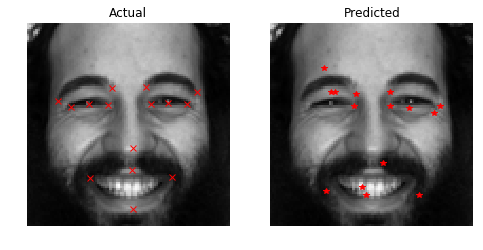

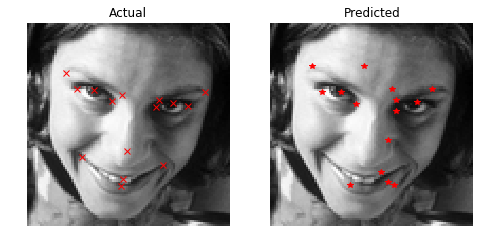

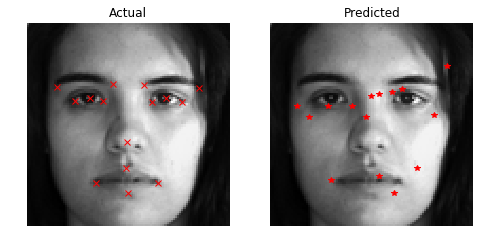

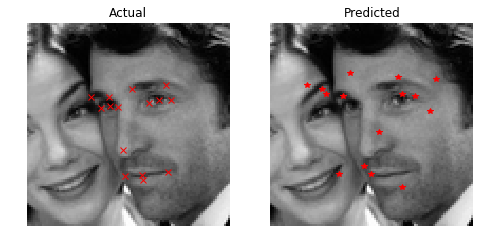

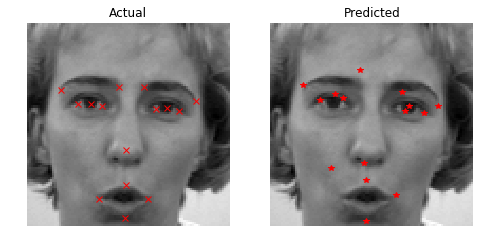

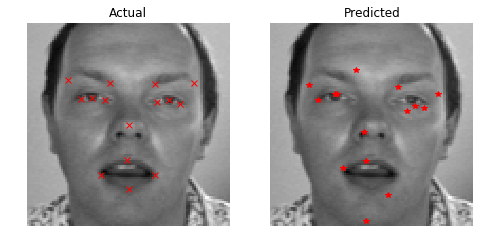

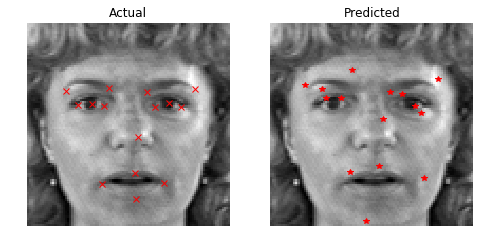

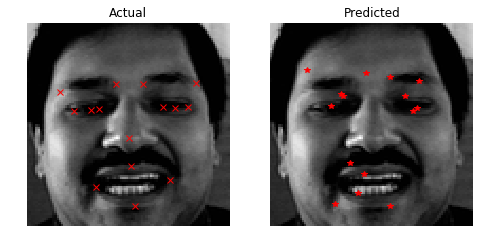

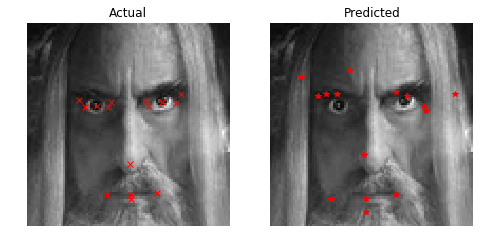

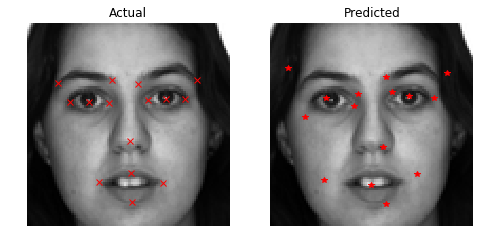

In [107]:
# comparison of a few predictions:

ex_start = 0                                 # starting index of set of images to compare
ex_end = 10                                  # stopping index

for i in range(ex_start,ex_end):
    plot_compare_images(X_test[i], Y_test[i,:], gnb_predicted[i,:] )
